<a href="https://colab.research.google.com/github/LeonSanders/tts_sft/blob/main/E2E_TensorflowTTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorflowTTS real time E2E-TTS demonstration

This notebook provides a demonstration of the realtime E2E-TTS using TensorflowTTS

- Github: https://github.com/TensorSpeech/TensorflowTTS
- Audio samples: https://tensorspeech.github.io/TensorflowTTS/
- Korean Colab: https://colab.research.google.com/drive/1ybWwOS5tipgPFttNulp77P6DAB5MtiuN?usp=sharing

## Install

In [12]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS
os.chdir("TensorFlowTTS")
!pip install  .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

fatal: destination path 'TensorFlowTTS' already exists and is not an empty directory.
Processing /content/TensorFlowTTS
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for TensorFlowTTS: filename=TensorFlowTTS-0.0-py3-none-any.whl size=131006 sha256=d676573d743e279ad26640d452391a2746674729571267723cdea9fe9d49fdca
  Stored in directory: /tmp/pip-ephem-wheel-cache-yfw6a59j/wheels/e5/36/fb/a502156a232342e4818fe60e0d477ab8bb2b7d890030fdf93c
Successfully built TensorFlowTTS
  Attempting uninstall: TensorFlowTTS
    Found existing installation: TensorFlowTTS 0.0
    Uninstalling TensorFlowTTS-0.0:
      Successfully uninstalled Tensor

In [13]:
!pip install git+https://github.com/repodiac/german_transliterate.git#egg=german_transliterate

  Cloning https://github.com/repodiac/german_transliterate.git to /tmp/pip-install-tc7qnc49/german-transliterate_546a05eded6e4163836305f05f7ab165
  Running command git clone -q https://github.com/repodiac/german_transliterate.git /tmp/pip-install-tc7qnc49/german-transliterate_546a05eded6e4163836305f05f7ab165


In [14]:
!pip install h5py==2.10.0

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.6.0 which is incompatible.
tensorflow-gpu 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


## Download pretrained feature generation model

You can select one from two models. Please only run the seletected model cells.


### (b) MelGAN + STFT Loss

In [15]:
print("Downloading MelGAN-STFT model...")
!gdown --id {"1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys"} -O melgan.stft-2M.h5
!gdown --id {"1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg"} -O melgan.stft_config.yml

Downloading...
From: https://drive.google.com/uc?id=1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys
To: /content/melgan.stft-2M.h5
100% 17.1M/17.1M [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg
To: /content/melgan.stft_config.yml
100% 1.77k/1.77k [00:00<00:00, 5.44MB/s]


## Load Model

In [16]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


### (a) Tacotron 2

In [17]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-ljspeech-en", name="tacotron2")

Downloading:   0%|          | 0.00/128M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

### (b) FastSpeech

In [18]:
fastspeech = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech-ljspeech-en", name="fastspeech")

Downloading:   0%|          | 0.00/121M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

### (c) FastSpeech2

In [19]:
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en", name="fastspeech2")

Downloading:   0%|          | 0.00/125M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

### (d) MelGAN Original

In [20]:
melgan = TFAutoModel.from_pretrained("tensorspeech/tts-melgan-ljspeech-en", name="melgan")

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.68k [00:00<?, ?B/s]

### (e) MelGAN STFT

In [21]:
melgan_stft_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/melgan_stft/conf/melgan_stft.v1.yaml')
melgan_stft = TFAutoModel.from_pretrained(
    config=melgan_stft_config,
    pretrained_path="melgan.stft-2M.h5",
    name="melgan_stft"
)

### (f) Multi-band MelGAN

In [22]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-ljspeech-en", name="mb_melgan")

Downloading:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

## Inference
- The first time model run inference will very slow cause by @tf.function.

In [23]:
processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-ljspeech-en")

Downloading:   0%|          | 0.00/3.57k [00:00<?, ?B/s]

In [24]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH":
    mel_before, mel_outputs, duration_outputs = text2mel_model.inference(
        input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MELGAN" or vocoder_name == "MELGAN-STFT":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  elif vocoder_name == "MB-MELGAN":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MELGAN, MELGAN-STFT and MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [25]:
input_text = "Bill got in the habit of asking himself “Is that thought true?” And if he wasn’t absolutely certain it was, he just let it go."

In [26]:
# setup window for tacotron2 if you want to try
tacotron2.setup_window(win_front=10, win_back=10)

### (a) Tacotron2 + MELGAN

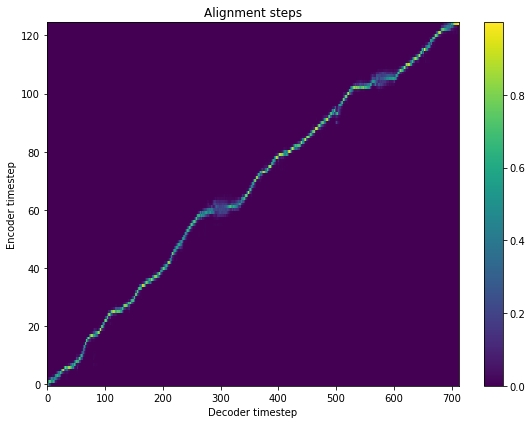

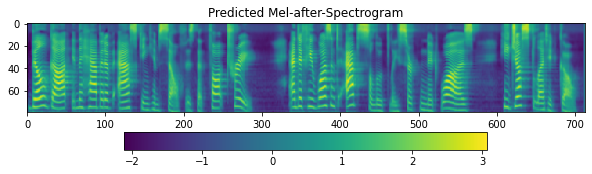

In [27]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan, "TACOTRON", "MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (b) Tacotron2 + MELGAN-STFT

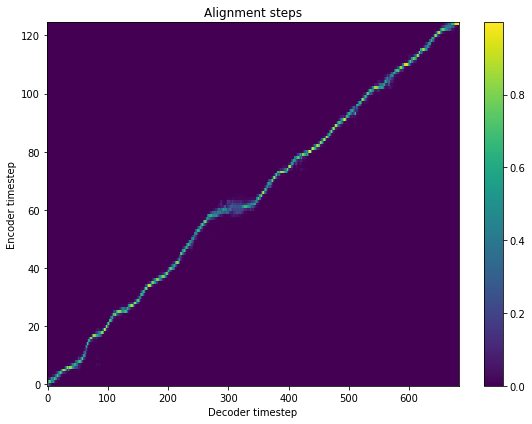

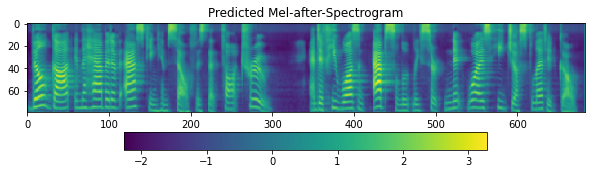

In [28]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan_stft, "TACOTRON", "MELGAN-STFT")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (c) Tacotron2 + MB-MELGAN

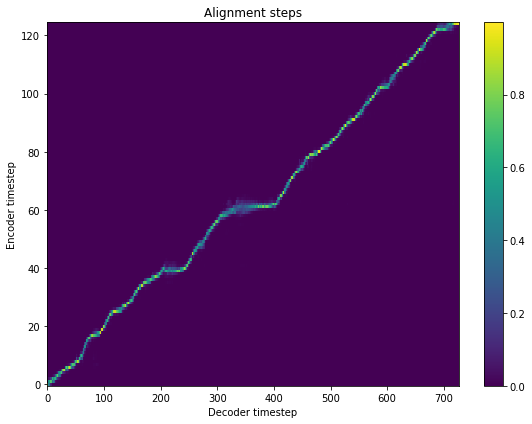

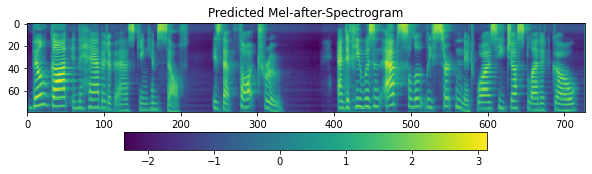

In [29]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (d) FastSpeech + MB-MELGAN

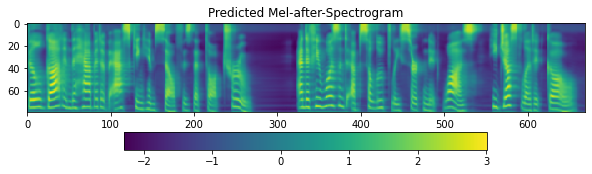

In [30]:
mels, audios = do_synthesis(input_text, fastspeech, mb_melgan, "FASTSPEECH", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (e) FastSpeech + MELGAN-STFT

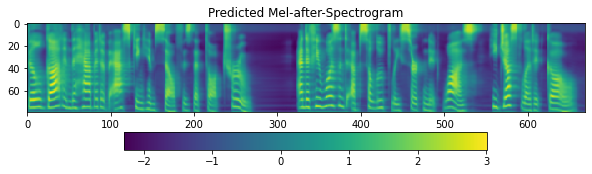

In [31]:
mels, audios = do_synthesis(input_text, fastspeech, melgan_stft, "FASTSPEECH", "MELGAN-STFT")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (f) FastSpeech + MELGAN

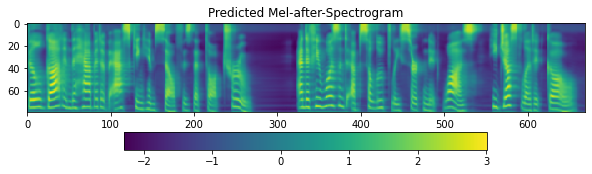

In [32]:
mels, audios = do_synthesis(input_text, fastspeech, melgan, "FASTSPEECH", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (g) FastSpeech2 + MB-MELGAN

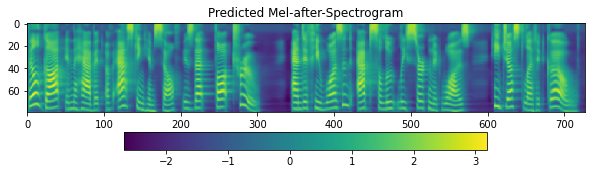

In [33]:
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (h) FastSpeech2 + MELGAN-STFT

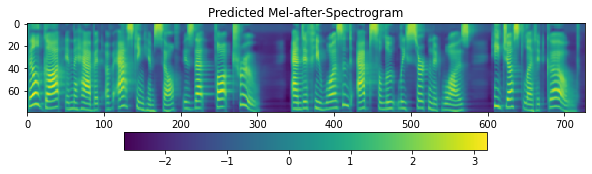

In [34]:
mels, audios = do_synthesis(input_text, fastspeech2, melgan_stft, "FASTSPEECH2", "MELGAN-STFT")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (i) FastSpeech2 + MELGAN

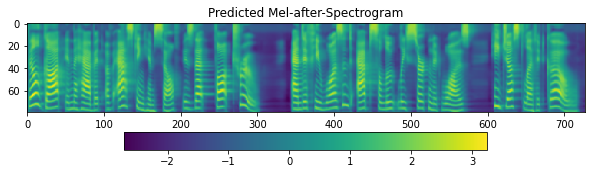

In [35]:
mels, audios = do_synthesis(input_text, fastspeech2, melgan, "FASTSPEECH2", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)